In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 20
d_H = 5
width = 1024  # 1024
bias = False
n_steps = 5000
base_lr = 5e-2
batch_size = 256

SEED = 42
pause = 1e-6

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/perp_dependence')

In [8]:
set_random_seeds(SEED)

## Data

In [9]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)

In [10]:
with torch.no_grad():
    y_val = torch.norm(X_val[:, :d_H], dim=1, keepdim=True, p=2)
    all_ys = torch.norm(all_Xs[:, :d_H], dim=1, keepdim=True, p=2)
print(y_val.shape)
print(all_ys.shape)

torch.Size([500, 1])
torch.Size([1280000, 1])


In [11]:
scale = 1.0
num = 100
#rs = np.array([0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 50.0, 80.0, 100.0, 150.0, 200.0]).reshape(-1,1)
rs = np.linspace(start=0., stop=5.0, num=num, endpoint=True) .reshape(-1,1)
with torch.no_grad():
    #e = torch.nn.functional.one_hot(torch.from_numpy(np.array(len(rs)*[d_H + 1])), num_classes=input_dim).float()
    e = torch.nn.functional.one_hot(torch.from_numpy(np.array(len(rs)*[d_H])), num_classes=input_dim).float()
    x = np.random.randn(input_dim)
    x[d_H:] = 0
    u_H = x / np.linalg.norm(x, ord=2)
    u_Hs = np.array([list(u_H) for _ in range(len(rs))])
    Xs_perp = torch.from_numpy(scale *u_Hs + (e.detach().numpy() * rs)).float()

In [12]:
Xs_perp

tensor([[ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2840, -0.0790,  0.3703,  ...,  0.0000,  0.0000,  0.0000]])

# Train network

In [13]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

train_losses = []
val_losses = []
y_hats_r = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
        val_losses.append(val_loss.detach().item())
        y_hat_r = network(Xs_perp).detach().numpy()
        y_hats_r.append(y_hat_r)
        
y_hats_r = np.array(y_hats_r)

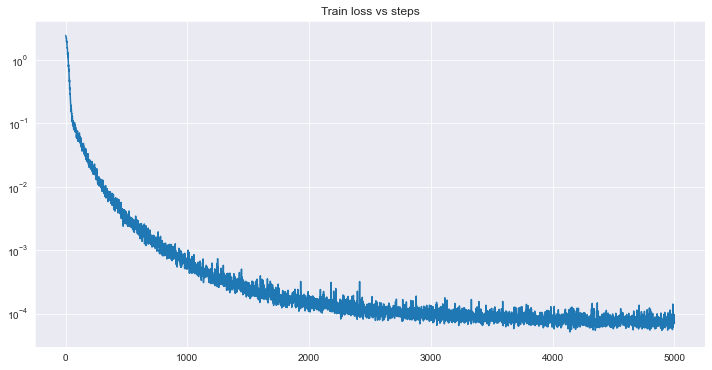

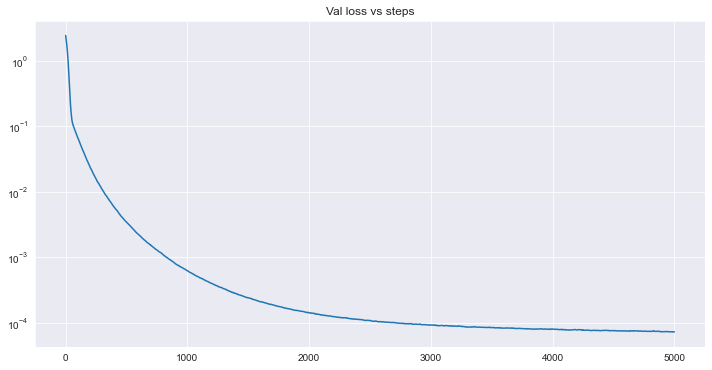

In [14]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.yscale('log')
plt.show()

figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.yscale('log')
plt.show()

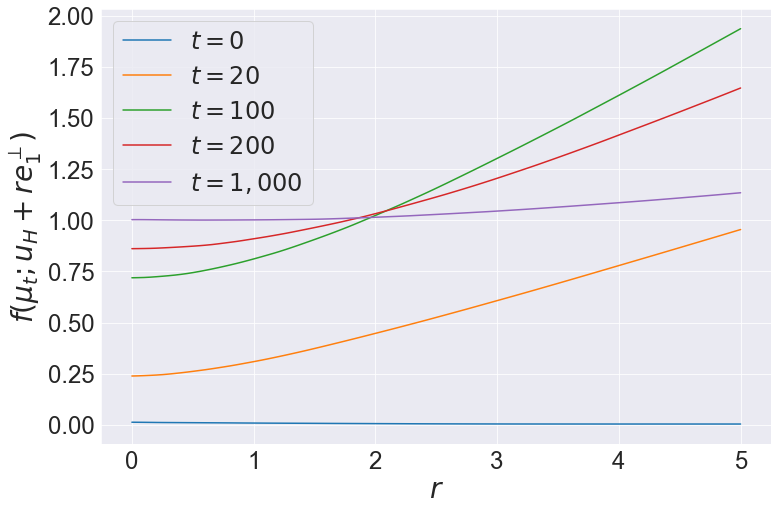

In [15]:
#ts = [0, 100, 500, 1000, 2000, 4000, 4999]
ts = [0, 20, 100, 200, 1000]

figure = plt.figure(figsize=(12, 8))
for t in ts:
    #plt.plot(rs, y_hats_r[t, :, 0], marker='o', label='$t={:,}$'.format(t))
    plt.plot(rs, y_hats_r[t, :, 0], label='$t={:,}$'.format(t))
#plt.title('$f(\\mu_t; u_H + r e_{\\perp, 1})$', fontsize=18)
plt.xlabel('$r$', fontsize=28)
plt.ylabel('$f(\\mu_t; u_H + r e^{\\perp}_{1})$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.yscale('log')
plt.legend(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'perp-depend-r.jpg'), bbox_inches='tight')
plt.show()

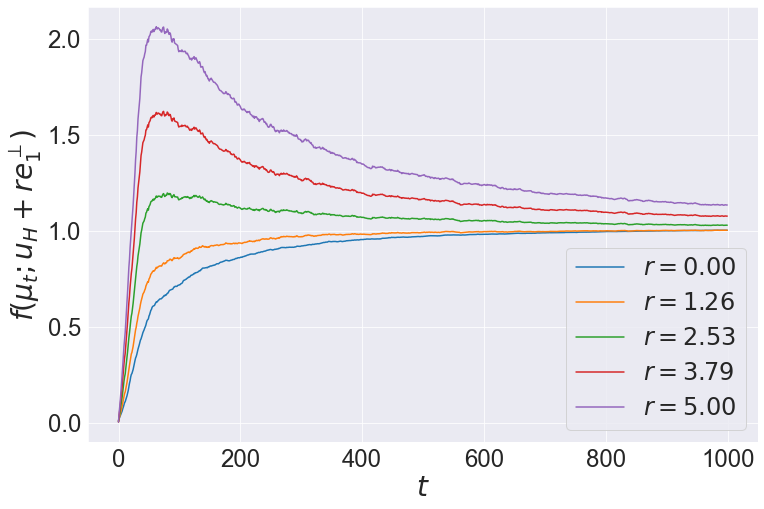

In [18]:
#ts = [0, 100, 500, 1000, 2000, 4000, 4999]
#ts = [0, 20, 100, 200, 1000]
sub_r_indices = [0, 25, 50, 75, 99]
t_max = 1000

figure = plt.figure(figsize=(12, 8))
for i in sub_r_indices:
    plt.plot(np.arange(len(y_hats_r[:t_max, i, 0])), y_hats_r[:t_max, i, 0], label='$r={:.2f}$'.format(rs[i, 0]))
#plt.title('$f(\\mu_t; u_H + r e^{\\perp}_1})$', fontsize=24)
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$f(\\mu_t; u_H + r e^{\\perp}_{1})$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.yscale('log')
plt.legend(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'perp-depend-t.jpg'), bbox_inches='tight')
plt.show()

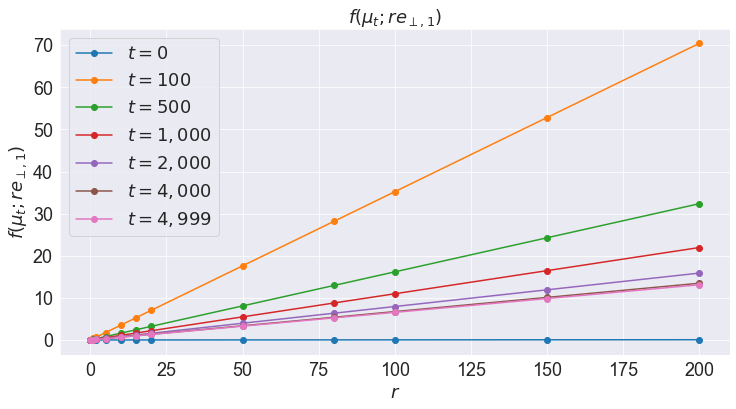

In [15]:
ts = [0, 100, 500, 1000, 2000, 4000, 4999]


figure = plt.figure(figsize=(12, 6))
for t in ts:
    plt.plot(rs, ys_r[t], marker='o', label='$t={:,}$'.format(t))
plt.title('$f(\\mu_t; r e_{\\perp, 1})$', fontsize=18)
plt.xlabel('$r$', fontsize=18)
plt.ylabel('$f(\\mu_t; r e_{\\perp, 1})$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'W-1-2.jpg'), bbox_inches='tight')
#plt.yscale('log')
plt.legend(fontsize=18)
plt.show()